# 数据读取

In [3]:
import os
import numpy as np
import pandas as pd
from collections import Counter

In [4]:
# 查看当前目录下的文件内容
os.listdir()

['val',
 'train',
 'label and phone.xls',
 'parameter_get.py',
 'some_package.py',
 'preds.npy',
 '.ipynb_checkpoints',
 'submmit.npy',
 'eda0.ipynb',
 'baseline.ipynb',
 'resnet_best_model.point',
 'baseline.py',
 'catboost_info',
 '.DS_Store',
 'resnet.py',
 'dnn.py',
 'model.point',
 'log_dnn_layer_1_512_layer_2_256_layer_3_128.csv',
 'dnn_no_fft.py',
 '__pycache__',
 'test']

In [5]:
train_path = './train'
val_path = './val'
test_path = './test'

In [6]:
# 查看目录里面的文件
print(os.listdir(train_path))
print(os.listdir(test_path))
print(os.listdir(val_path))

['10type_sort_train_data_8192.npy', '10type_sort_train_label_8192.npy']
['10type_sort_test_data_8192.npy']
['10type_sort_eval_data_8192.npy', '10type_sort_eval_label_8192.npy']


In [7]:
# 读取训练集，测试集和验证集
train = np.load(train_path + '/' + '10type_sort_train_data_8192.npy')
test = np.load(test_path + '/' + '10type_sort_test_data_8192.npy')
val = np.load(val_path + '/' + '10type_sort_eval_data_8192.npy')

In [8]:
# 读取训练集和验证集的标签，测试集是没有标签的，需要你使用模型进行分类，并将结果进行提交
train_label = np.load(train_path + '/' + '10type_sort_train_label_8192.npy')
val_label = np.load(val_path + '/' + '10type_sort_eval_label_8192.npy')

In [9]:
Counter(val_label)

Counter({5: 2118,
         4: 1558,
         8: 1714,
         3: 5745,
         0: 1404,
         6: 3398,
         7: 1248,
         9: 1386,
         1: 3365,
         2: 1467})

In [10]:
# 查看数据的shape，可以发现序列长度都是8192
print(train.shape)
print(test.shape)
print(val.shape)

(70209, 8192)
(23403, 8192)
(23403, 8192)


In [11]:
# 查看训练集和验证集的标签数量是不是对应
print(train_label.shape)
print(val_label.shape)

(70209,)
(23403,)


In [12]:
# 查看标签结果，注意分类标签应该从0开始
print(train_label)

[0 0 0 ... 9 9 9]


# 数据处理

In [13]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler

In [14]:
import matplotlib.pyplot as plt

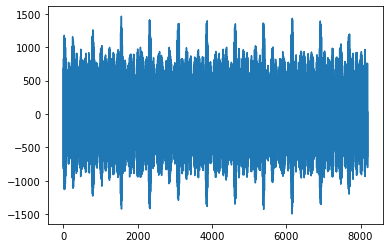

In [15]:
plt.plot(train[0])

In [16]:
def get_fft_and_scaler(data, start=5192, end=8192):
    data = np.fft.fft(data)
    data = np.abs(data)
    data = data/np.expand_dims(data.max(axis=1), axis=1)
    return data[:,start:end]

In [17]:
train_sp = get_fft_and_scaler(train)
test_sp = get_fft_and_scaler(test)
val_sp = get_fft_and_scaler(val)
#train_fft = np.fft.fft(train)
#val_fft = np.fft.fft(val)
#test_fft = np.fft.fft(test)

In [18]:
#train_abs = np.abs(train_fft)
#val_abs = np.abs(val_fft)
#test_abs = np.abs(test_fft)

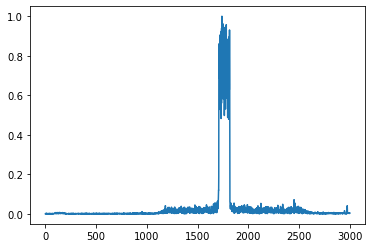

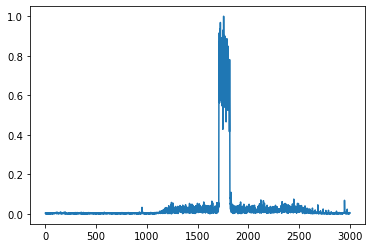

In [19]:
plt.figure()
plt.plot(train_sp[0])
plt.figure()
plt.plot(val_sp[0])

# DNN建模分析

In [17]:
# dnn模型构建
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import random

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
# 固定随机数种子，确保实验的可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [ ]:
# 搭建DNN模型
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.dnn = nn.Sequential(
            nn.BatchNorm1d(3000),
            nn.Linear(3000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        x = self.dnn(x)
        return F.softmax(x, dim=1)

In [21]:
for i in Counter(train_label).values():
    print(i)

4257
10081
4270
17187
4746
6337
10298
3694
5058
4281


In [22]:
# 将数据转换成pytorch的tensor
batch_size = 128

train_tensor = torch.tensor(train_sp).float()
y_train_tensor = torch.tensor(train_label).long()
val_tensor = torch.tensor(val_sp).float()
y_val_tensor = torch.tensor(val_label).long()

# 使用Dataloader对数据进行封装
train_tensor = TensorDataset(train_tensor, y_train_tensor)
val_tensor = TensorDataset(val_tensor, y_val_tensor)


train_loader = DataLoader(train_tensor, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=batch_size)

In [64]:
lr = 0.0001
gamma = 1
step_size = 5
EPOCH = 80

model = DNN().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
lf = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [65]:
print(model)

DNN(
  (dnn): Sequential(
    (0): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=3000, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [66]:
train_best = 1000
for epoch in range(EPOCH):
    model.train()
    train_total_acc = 0
    
    for feature, label in tqdm(train_loader):
        feature = feature.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        preds = model(feature)
        loss = lf(preds, label)
        loss.backward()
        optimizer.step()
        
        train_total_acc += model(feature).argmax(dim=1).eq(label).sum().item()
        
        feature.cpu()
        label.cpu()
    
    model.eval()
    with torch.no_grad():
        val_total_acc = 0
        for feature, label in tqdm(val_loader):
            feature = feature.cuda()
            label = label.cuda()
            val_total_acc += model(feature).argmax(dim=1).eq(label).sum().item()
            
            feature.cpu()
            label.cpu()
    
    scheduler.step()
    print(f'epoch:{epoch:2} loss:{loss:4f} train_acc:{train_total_acc/len(train_label):4f}')
    print('val_acc:{:4f}'.format(val_total_acc/len(val_label)))
    
    # 保存最佳的训练模型
    if loss <= train_best:
        train_best = loss
        torch.save(model.state_dict(), './model.point')

  3%|▎         | 15/548 [00:00<00:03, 141.27it/s]

epoch: 0 loss:1.810878 train_acc:0.549317
val_acc:0.493911


  2%|▏         | 12/548 [00:00<00:04, 114.37it/s]

epoch: 1 loss:1.819555 train_acc:0.659901
val_acc:0.498739


  3%|▎         | 16/548 [00:00<00:03, 152.51it/s]

epoch: 2 loss:1.798020 train_acc:0.694085
val_acc:0.491347


  2%|▏         | 12/548 [00:00<00:04, 113.12it/s]

epoch: 3 loss:1.783508 train_acc:0.721218
val_acc:0.481135


  3%|▎         | 16/548 [00:00<00:03, 151.38it/s]

epoch: 4 loss:1.759122 train_acc:0.739777
val_acc:0.492202


  2%|▏         | 13/548 [00:00<00:04, 129.76it/s]

epoch: 5 loss:1.771167 train_acc:0.756698
val_acc:0.479938


  3%|▎         | 15/548 [00:00<00:03, 148.55it/s]

epoch: 6 loss:1.662324 train_acc:0.776382
val_acc:0.482630


  2%|▏         | 13/548 [00:00<00:04, 128.80it/s]

epoch: 7 loss:1.688476 train_acc:0.795681
val_acc:0.494766


  3%|▎         | 14/548 [00:00<00:04, 133.14it/s]

epoch: 8 loss:1.691044 train_acc:0.805467
val_acc:0.505106


  3%|▎         | 19/548 [00:00<00:02, 181.18it/s]

epoch: 9 loss:1.668591 train_acc:0.815280
val_acc:0.487630


  3%|▎         | 18/548 [00:00<00:03, 172.26it/s]

epoch:10 loss:1.657607 train_acc:0.821120
val_acc:0.504593


  2%|▏         | 13/548 [00:00<00:04, 125.89it/s]

epoch:11 loss:1.639763 train_acc:0.826960
val_acc:0.500961


  3%|▎         | 16/548 [00:00<00:03, 157.07it/s]

epoch:12 loss:1.651890 train_acc:0.831674
val_acc:0.496389


  3%|▎         | 15/548 [00:00<00:03, 140.53it/s]

epoch:13 loss:1.591116 train_acc:0.837272
val_acc:0.488570


  3%|▎         | 16/548 [00:00<00:03, 154.01it/s]

epoch:14 loss:1.632923 train_acc:0.842456
val_acc:0.507627


  3%|▎         | 14/548 [00:00<00:03, 137.07it/s]

epoch:15 loss:1.628713 train_acc:0.844934
val_acc:0.501218


  3%|▎         | 16/548 [00:00<00:03, 152.65it/s]

epoch:16 loss:1.618376 train_acc:0.848780
val_acc:0.491817


 49%|████▊     | 267/548 [00:01<00:01, 163.87it/s]


KeyboardInterrupt: 

In [18]:
model(torch.tensor(val).float().cuda()).cpu().argmax(dim=1).eq(torch.tensor(val_label)).sum()/len(val_label)

tensor(0.3997)

# Xgboost模型

In [2]:
import xgboost as xgb
# https://github.com/dmlc/xgboost/tree/master/demo
# https://github.com/dmlc/xgboost/blob/master/demo/gpu_acceleration/cover_type.py
# https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

In [20]:
xg_train = xgb.DMatrix(train_sp, label=train_label)
xg_val = xgb.DMatrix(val_sp, label=val_label)
xg_test = xgb.DMatrix(test_sp)

In [27]:
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['nthread'] = -1
param['num_class'] = 10
param['tree_method']: 'gpu_hist'
param['eval_metric'] = 'mlogloss'
#watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 15

In [28]:
bst = xgb.train(param, xg_train, num_round)
# get prediction
pred = bst.predict(xg_val)
acc_rate = np.sum(pred == val_label) / val_label.shape[0]
print('Test acc using softmax = {}'.format(acc_rate))

Test acc using softmax = 0.44135367260607616


In [ ]:
ans = model.predict(x_test)
np.save(ans, 'xgboost_preds.npy')

# Catboost

In [20]:
from catboost import Pool, CatBoostClassifier
# 参考：https://github.com/catboost/catboost/blob/master/catboost/tutorials/classification/classification_tutorial.ipynb

In [42]:
model = CatBoostClassifier(#loss_function="Logloss",
                           eval_metric="AUC",
                           task_type="GPU",
                           learning_rate=0.1,
                           iterations=2000,
                           l2_leaf_reg=50,
                           random_seed=43,
                           od_type="Iter",
                           depth=5,
                           early_stopping_rounds=15000,
                           border_count=64,
                           loss_function='MultiClass',
                           #has_time= True 
                          )

In [46]:
#model.fit(
#    train_sp, train_label,
#    #eval_set=(val_sp, val_label),
#)

In [44]:
preds = model.predict(val_sp)

In [45]:
(preds.flatten() == val_label).sum() / len(val_label)

0.484254155450156

In [27]:
ans = model.predict(test_sp)

In [29]:
print(ans)

[[1]
 [3]
 [9]
 ...
 [8]
 [3]
 [3]]


# LSTM模型

In [44]:
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [45]:
batch_size = 128

train_tensor = torch.tensor(train_sp).float()
y_train_tensor = torch.tensor(train_label).long()
val_tensor = torch.tensor(val_sp).float()
y_val_tensor = torch.tensor(val_label).long()

# 使用Dataloader对数据进行封装
train_tensor = TensorDataset(train_tensor, y_train_tensor)
val_tensor = TensorDataset(val_tensor, y_val_tensor)


train_loader = DataLoader(train_tensor, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=batch_size)

In [49]:
sequence_length = 1
input_size = 3000
hidden_size = 512
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 30
learning_rate = 0.01
gamma = 0.9
step_size=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 官网默认的输入是seq_len, batch, input_size,这里将batch first=True放在第一个
        # seq len 相当于一句话的长度， input size相当于每个单词的向量长度
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 初始化两个向量的值, 因为这里是两层的lstm
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # 前向传播，这里只需要out即可
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # 使用全连层进行分类
        out = self.fc(out[:, -1, :])
        return out

In [55]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma) # 学习方式
# Train the model
total_step = len(train_loader)
train_acc, val_acc = [], []

In [56]:
for epoch in range(num_epochs):
    epoch_accuracy = 0
    epoch_loss = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # reshape的维度变成了(batch size, 28, 28)
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    # val the model
    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for images, labels in tqdm(val_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).float().mean()
            epoch_val_accuracy += acc / len(val_loader)

    scheduler.step()
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'val acc:{epoch_val_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    val_acc.append(epoch_val_accuracy)


  3%|▎         | 14/548 [00:00<00:03, 138.25it/s]

EPOCH: 0, train loss:1.5093, train acc:0.5071
val acc:0.4722


  3%|▎         | 14/548 [00:00<00:03, 138.59it/s]

EPOCH: 1, train loss:0.9834, train acc:0.6626
val acc:0.5351


  3%|▎         | 14/548 [00:00<00:03, 138.43it/s]

EPOCH: 2, train loss:0.8539, train acc:0.7011
val acc:0.5221


  3%|▎         | 14/548 [00:00<00:03, 138.72it/s]

EPOCH: 3, train loss:0.7638, train acc:0.7316
val acc:0.5341


  3%|▎         | 14/548 [00:00<00:03, 138.25it/s]

EPOCH: 4, train loss:0.7109, train acc:0.7504
val acc:0.5175


  3%|▎         | 16/548 [00:00<00:03, 151.01it/s]

EPOCH: 5, train loss:0.6657, train acc:0.7653
val acc:0.4767


  3%|▎         | 16/548 [00:00<00:03, 150.79it/s]

EPOCH: 6, train loss:0.6236, train acc:0.7812
val acc:0.5093


  3%|▎         | 15/548 [00:00<00:03, 149.70it/s]

EPOCH: 7, train loss:0.5843, train acc:0.7948
val acc:0.5088


  3%|▎         | 16/548 [00:00<00:03, 151.05it/s]

EPOCH: 8, train loss:0.5521, train acc:0.8059
val acc:0.5222


  3%|▎         | 16/548 [00:00<00:03, 150.92it/s]

EPOCH: 9, train loss:0.5164, train acc:0.8188
val acc:0.5004


  3%|▎         | 16/548 [00:00<00:03, 150.28it/s]

EPOCH:10, train loss:0.4945, train acc:0.8250
val acc:0.5269


  3%|▎         | 16/548 [00:00<00:03, 150.95it/s]

EPOCH:11, train loss:0.4648, train acc:0.8353
val acc:0.5279


  3%|▎         | 16/548 [00:00<00:03, 150.81it/s]

EPOCH:12, train loss:0.4454, train acc:0.8404
val acc:0.5057


  3%|▎         | 14/548 [00:00<00:03, 137.99it/s]

EPOCH:13, train loss:0.4230, train acc:0.8497
val acc:0.5101


  3%|▎         | 14/548 [00:00<00:03, 134.62it/s]

EPOCH:14, train loss:0.4050, train acc:0.8562
val acc:0.5277


  3%|▎         | 15/548 [00:00<00:03, 145.54it/s]

EPOCH:15, train loss:0.3901, train acc:0.8615
val acc:0.5180


  3%|▎         | 14/548 [00:00<00:03, 134.29it/s]

EPOCH:16, train loss:0.3725, train acc:0.8679
val acc:0.4915


  3%|▎         | 14/548 [00:00<00:03, 137.54it/s]

EPOCH:17, train loss:0.3583, train acc:0.8719
val acc:0.4951


  3%|▎         | 14/548 [00:00<00:03, 134.18it/s]

EPOCH:18, train loss:0.3443, train acc:0.8768
val acc:0.5268


  3%|▎         | 14/548 [00:00<00:03, 133.58it/s]

EPOCH:19, train loss:0.3347, train acc:0.8797
val acc:0.4979


  3%|▎         | 14/548 [00:00<00:03, 139.50it/s]

EPOCH:20, train loss:0.3225, train acc:0.8854
val acc:0.5034


  3%|▎         | 14/548 [00:00<00:03, 135.53it/s]

EPOCH:21, train loss:0.3118, train acc:0.8894
val acc:0.5089


  3%|▎         | 15/548 [00:00<00:03, 142.98it/s]

EPOCH:22, train loss:0.3042, train acc:0.8927
val acc:0.5104


  3%|▎         | 14/548 [00:00<00:03, 138.16it/s]

EPOCH:23, train loss:0.2955, train acc:0.8949
val acc:0.5106


  3%|▎         | 14/548 [00:00<00:03, 138.77it/s]

EPOCH:24, train loss:0.2886, train acc:0.8969
val acc:0.4917


  3%|▎         | 14/548 [00:00<00:04, 131.86it/s]

EPOCH:25, train loss:0.2807, train acc:0.9011
val acc:0.5143


  3%|▎         | 14/548 [00:00<00:03, 138.71it/s]

EPOCH:26, train loss:0.2733, train acc:0.9036
val acc:0.5237


  3%|▎         | 14/548 [00:00<00:03, 137.91it/s]

EPOCH:27, train loss:0.2687, train acc:0.9048
val acc:0.4992


  3%|▎         | 14/548 [00:00<00:03, 137.09it/s]

EPOCH:28, train loss:0.2622, train acc:0.9079
val acc:0.4980


100%|██████████| 183/183 [00:00<00:00, 441.33it/s]

EPOCH:29, train loss:0.2566, train acc:0.9092
val acc:0.5052


# Transformer分析

In [73]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
import math
from torchvision import datasets, transforms
# 这里使用Fashion minist数据集，使用transformer进行特征提取
# 使用linear层进行下游任务分类
# 参考：https://github.com/oliverguhr/transformer-time-series-prediction/blob/master/transformer-multistep.py

In [88]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=3000, max_len=1):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# 这里feature size必须可以整除以nhead
class Transformer(nn.Module):
    def __init__(self, src_len=1, d_model=3000, num_layers=4, nhead=8):
        super().__init__()
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model).to(device)
        self.nhead = nhead
        self.d_model = d_model
        self.src_len = src_len
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=self.nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        # 这里encoder输出的维度还是[batch size, max_len, embedding dim]
        # 所以embedding dim维度应该是 max len * embedding dim
        self.decoder = nn.Linear(self.d_model*self.src_len, 10)
        self.init_weights()

    def forward(self, x):
        #if self.src_mask is None:
        #    mask = self._generate_square_subsequent_mask(len(x)).to(device)
        #    self.src_mask = mask
        # 输入x加上位置编码后，得到encoder的输入
        x = self.pos_encoder(x)
        # 这里mask不是要免除padding=0后，softmax的影响吗
        # encoder mask讲解参考下面链接
        # https://medium.com/data-scientists-playground/transformer-encoder-mask%E7%AF%87-dc2c3abfe2e
        # 这里不需要为encoder添加mask，首先每个长度都是一样
        # 什么时候需要？参考：https://github.com/pytorch/tutorials/blob/master/beginner_source/transformer_tutorial.py
        # 大致意思是说当我们要做seq2seq任务时，encoder只能接受前面位置的mask，要对后面位置的seq进行mask。
        # 当输入的batch size 长度不一样时候，也需要mask
        x = self.transformer_encoder(x)#, self.src_mask)
        x = self.decoder(x.permute(1, 0, 2).reshape(-1, self.d_model*self.src_len))
        return x

    # 将decoder 的偏置转换成0， 将权重进行标准化
    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    # 将输入的序列进行mask操作
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

## 数据转换

In [89]:
import numpy as np

In [39]:
train_tensor = torch.tensor(train_sp).float()
y_train_tensor = torch.tensor(train_label).long()
val_tensor = torch.tensor(val_sp).float()
y_val_tensor = torch.tensor(val_label).long()

# 使用Dataloader对数据进行封装
batch_size = 128
train_tensor = TensorDataset(train_tensor, y_train_tensor)
val_tensor = TensorDataset(val_tensor, y_val_tensor)


train_loader = DataLoader(train_tensor, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=batch_size)

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sequence_length = 1
# input_size 相当于embedding dim
model = Transformer().to(device)
input_size = 3000
num_epochs = 80
learning_rate = 1e-4
gamma = 0.9
step_size=1

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma) # 学习方式

# Train the model
total_step = len(train_loader)
train_acc, val_acc = [], []
# seq_len 相当于 max len， 即每句话切分的最大长度

train_best = None
best_loss = 1000

In [92]:
for epoch in range(num_epochs):
    epoch_accuracy = 0
    epoch_loss = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # reshape的维度变成了(batch size, 28, 28)
        images = images.reshape(-1, sequence_length, input_size)
        images = images.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    # val the model
    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for images, labels in tqdm(val_loader):
            images = images.reshape(-1, sequence_length, input_size)
            images = images.permute(1, 0, 2).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).float().mean()
            epoch_val_accuracy += acc / len(val_loader)

    if loss <= best_loss:
        best_model = model
        best_loss = loss

    scheduler.step()
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'val acc:{epoch_val_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    val_acc.append(epoch_val_accuracy)

# 保存模型
torch.save(best_model.state_dict(), './transformer_model.point')

# 读取模型参数
# model.load_state_dict(torch.load('transformer_model.point'))

  0%|          | 2/548 [00:00<00:38, 14.14it/s]

EPOCH: 0, train loss:3.0662, train acc:0.1697
val acc:0.2455


  0%|          | 2/548 [00:00<00:40, 13.62it/s]

EPOCH: 1, train loss:2.4007, train acc:0.1802
val acc:0.1452


  0%|          | 2/548 [00:00<00:38, 14.07it/s]

EPOCH: 2, train loss:2.3348, train acc:0.1894
val acc:0.2455


  0%|          | 2/548 [00:00<00:36, 15.09it/s]

EPOCH: 3, train loss:2.2458, train acc:0.2243
val acc:0.3387


  0%|          | 2/548 [00:00<00:37, 14.75it/s]

EPOCH: 4, train loss:1.9161, train acc:0.3803
val acc:0.4727


  0%|          | 2/548 [00:00<00:37, 14.59it/s]

EPOCH: 5, train loss:1.7717, train acc:0.4390
val acc:0.4702


  0%|          | 2/548 [00:00<00:36, 14.80it/s]

EPOCH: 6, train loss:1.7033, train acc:0.4643
val acc:0.4720


  0%|          | 0/548 [00:00<?, ?it/s]

EPOCH: 7, train loss:1.5680, train acc:0.4995
val acc:0.4541


  0%|          | 0/548 [00:00<?, ?it/s]

EPOCH: 8, train loss:1.4367, train acc:0.5313
val acc:0.4917


  0%|          | 2/548 [00:00<00:36, 14.85it/s]

EPOCH: 9, train loss:1.3241, train acc:0.5605
val acc:0.4959


  0%|          | 2/548 [00:00<00:37, 14.72it/s]

EPOCH:10, train loss:1.2374, train acc:0.5846
val acc:0.4958


  0%|          | 2/548 [00:00<00:37, 14.66it/s]

EPOCH:11, train loss:1.1666, train acc:0.6057
val acc:0.4897


  0%|          | 0/548 [00:00<?, ?it/s]

EPOCH:12, train loss:1.1173, train acc:0.6206
val acc:0.4679


  0%|          | 2/548 [00:00<00:37, 14.71it/s]

EPOCH:13, train loss:1.0729, train acc:0.6364
val acc:0.4841


  0%|          | 2/548 [00:00<00:37, 14.59it/s]

EPOCH:14, train loss:1.0426, train acc:0.6453
val acc:0.5018


  0%|          | 2/548 [00:00<00:38, 14.34it/s]

EPOCH:15, train loss:0.9937, train acc:0.6612
val acc:0.4865


  0%|          | 2/548 [00:00<00:37, 14.56it/s]

EPOCH:16, train loss:0.9568, train acc:0.6746
val acc:0.5256


  0%|          | 2/548 [00:00<00:37, 14.50it/s]

EPOCH:17, train loss:0.9261, train acc:0.6822
val acc:0.4929


  0%|          | 2/548 [00:00<00:36, 14.83it/s]

EPOCH:18, train loss:0.9007, train acc:0.6935
val acc:0.5005


  0%|          | 0/548 [00:00<?, ?it/s]

EPOCH:19, train loss:0.8887, train acc:0.6955
val acc:0.4814


  0%|          | 2/548 [00:00<00:36, 14.93it/s]

EPOCH:20, train loss:0.8581, train acc:0.7045
val acc:0.5018


  0%|          | 2/548 [00:00<00:37, 14.73it/s]

EPOCH:21, train loss:0.8459, train acc:0.7087
val acc:0.4829


  0%|          | 2/548 [00:00<00:37, 14.71it/s]

EPOCH:22, train loss:0.8260, train acc:0.7135
val acc:0.4768


  0%|          | 2/548 [00:00<00:36, 14.91it/s]

EPOCH:23, train loss:0.8170, train acc:0.7168
val acc:0.4852


  0%|          | 2/548 [00:00<00:36, 15.03it/s]

EPOCH:24, train loss:0.8046, train acc:0.7207
val acc:0.5077


  0%|          | 2/548 [00:00<00:37, 14.73it/s]

EPOCH:25, train loss:0.7930, train acc:0.7253
val acc:0.5002


 80%|████████  | 439/548 [00:49<00:12,  8.92it/s]


KeyboardInterrupt: 

## 模型保存部分

In [17]:
# 保存模型权重
#torch.save(model.state_dict(), './model.point')
# 加载模型权重
model.load_state_dict(torch.load('model.point'))

<All keys matched successfully>

## 生成预测结果

In [54]:
preds = model(torch.tensor(test).float().cuda()).argmax(dim=1)

In [55]:
print(preds.shape), print(test,)

torch.Size([23403])


In [67]:
# 保存预测结果, 注意提交preds.npy文件
np.save('preds.npy', preds.cpu().numpy())

# Resnet模型

## 数据处理

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from scipy import signal
import gc
from torchvision import models

In [20]:
train_sp = get_fft_and_scaler(train)
test_sp = get_fft_and_scaler(test)
val_sp = get_fft_and_scaler(val)

## STFT画图

In [37]:
# 调高noverlap y轴会变大，调低窗口数量，y轴会变小
f, t, zxx = signal.stft(train_sp[0], fs=122.68e6, nfft=126, window=signal.get_window('hann', 30), noverlap=6, nperseg=30, return_onesided=False)
print(zxx.shape)

(126, 126)


In [38]:
import matplotlib.pyplot as plt

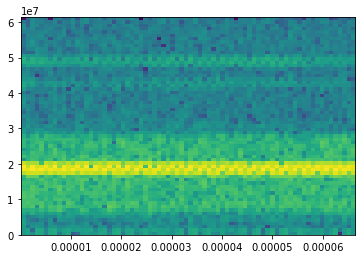

In [39]:
plt.figure()
plt.specgram(
    train[0],
    NFFT=128,
    Fs=122.68e6,
    noverlap=18,
) 
plt.show()

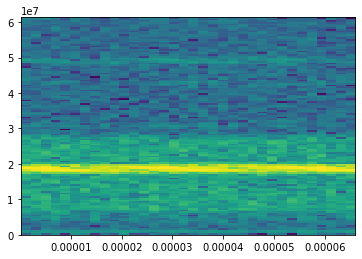

In [53]:
plt.figure()
plt.specgram(
    val[0],
    NFFT=256,
    Fs=122.68e6,
    noverlap=18,
) 
plt.show()

In [21]:
print(zxx.shape)

(251, 251)


In [40]:
def get_fft_and_scaler(data, start=5192, end=8192):
    data = np.fft.fft(data)
    data = np.abs(data)
    data = data/np.expand_dims(data.max(axis=1), axis=1)
    return data[:,start:end]

def get_stft(data, nfft=126, x=126, y=126, windows=30, oneside=False, overlap=6, dtype='complex64'):
    fs = 122.68e6
    result = np.zeros((data.shape[0], x, y), dtype=dtype)
    for idx, i in enumerate(tqdm(data)):
        f, t, zxx = signal.stft(
        i, 
        fs=fs,
        nfft=nfft,
        window=signal.get_window('hann', windows),
        noverlap=overlap,
        nperseg=windows,
        return_onesided=oneside) # 设置双边谱
        result[idx, :] = zxx[:, :].astype(dtype)
    return result
    
def get_image(stft, dtype='float32'):
    real = np.zeros_like(stft, dtype=dtype)
    imag = np.zeros_like(stft, dtype=dtype)
    angel = np.zeros_like(stft, dtype=dtype)
    for idx, i in enumerate(tqdm(stft)):
        temp_imag = i.imag
        real[idx, :] = i.real.astype(dtype)
        imag[idx, :] = i.imag.astype(dtype)
        angel[idx, :] = np.arctan(i.real/i.imag).astype(dtype)
    length = len(real)
    image = np.stack([real, imag, angel], axis=1) # 这里只要将维度设置为1即可
    del real, imag, angel; gc.collect()
    return image

In [41]:
stft = get_stft(train_sp)

image = get_image(stft)
del stft; gc.collect()

 15%|█▍        | 10527/70209 [00:05<00:28, 2101.22it/s]


KeyboardInterrupt: 

In [24]:
model = models.resnet50()

# 这里改成自适应，因为主要是Maxpooling层减小图片尺寸，只要改成自适应就好了
for name, layer in model.named_modules():
    if isinstance(layer, nn.MaxPool2d):
        model.maxpool = nn.AdaptiveAvgPool2d((7, 7))    

n_class = 10
numFit = model.fc.in_features
model.fc = nn.Linear(numFit, n_class) # 直接修改最后一层

In [25]:
class MyDataset(Dataset):
    def __init__(self, file_list, label_list):
        self.file_list = file_list
        self.label_list = label_list
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self, idx):
        img = torch.tensor(self.file_list[idx])
        label = self.label_list[idx]
        
        return img, label

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
image_labels = torch.tensor(train_label)
x_train, x_test, y_train, y_test = train_test_split(image, image_labels, test_size=0.3, shuffle=True)

In [29]:
batch_size = 64
train_data = MyDataset(x_train, y_train)
test_data = MyDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

device_count = torch.cuda.device_count()
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")

if device_count > 1:
    model = nn.DataParallel(model,device_ids=range(device_count)) # multi-GPU
    model.to(device)

else:
    model = model.cuda()

In [30]:
batch_size = 64
epochs = 10
lr = 0.001
gamma = 0.9
step_size = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma) # 学习方式

# 训练模型
train_acc, test_acc = [], []

In [31]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.cuda()
        label = label.cuda()
        output = model(data)
    
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        data.cpu()
        label.cpu()
        
    with torch.no_grad():
        epoch_test_accuracy = 0
        epoch_test_loss = 0
        for data, label in tqdm(test_loader):
            data = data.cuda()
            label = label.cuda()
            
            test_output = model(data)
            test_loss = criterion(test_output, label)
            
            acc = (test_output.argmax(dim=1) == label).float().mean()
            epoch_test_accuracy += acc / len(test_loader)
            epoch_test_loss += test_loss / len(test_loader)
            data.cpu()
            label.cpu()
    scheduler.step()        
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'test loss:{epoch_test_loss:.4f}, test acc:{epoch_test_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    test_acc.append(epoch_test_accuracy)

100%|██████████| 330/330 [00:43<00:00,  7.54it/s]


EPOCH: 0, train loss:2.3577, train acc:0.2307
test loss:2.2446, test acc:0.2646


100%|██████████| 330/330 [00:42<00:00,  7.82it/s]


EPOCH: 1, train loss:2.1968, train acc:0.2822
test loss:2.1744, test acc:0.3009


100%|██████████| 330/330 [00:41<00:00,  7.99it/s]


EPOCH: 2, train loss:1.8964, train acc:0.3908
test loss:1.6364, test acc:0.4719


  0%|          | 0/768 [00:00<?, ?it/s]

EPOCH: 3, train loss:1.5857, train acc:0.4906
test loss:1.4556, test acc:0.5180


100%|██████████| 330/330 [00:39<00:00,  8.27it/s]


EPOCH: 4, train loss:1.4016, train acc:0.5430
test loss:1.3863, test acc:0.5527


100%|██████████| 330/330 [00:41<00:00,  8.03it/s]


EPOCH: 5, train loss:1.3602, train acc:0.5495
test loss:1.2562, test acc:0.5784


100%|██████████| 330/330 [00:40<00:00,  8.14it/s]


EPOCH: 6, train loss:1.1469, train acc:0.6177
test loss:1.1327, test acc:0.6295


  0%|          | 0/768 [00:00<?, ?it/s]

EPOCH: 7, train loss:1.0187, train acc:0.6570
test loss:0.9908, test acc:0.6660


  0%|          | 0/768 [00:00<?, ?it/s]

EPOCH: 8, train loss:0.9575, train acc:0.6722
test loss:0.9815, test acc:0.6689


100%|██████████| 330/330 [00:39<00:00,  8.33it/s]

EPOCH: 9, train loss:0.9131, train acc:0.6849
test loss:0.9100, test acc:0.6931


In [144]:
# 直接将所有的放进去容易显存溢出，所以要分批次放入
model(torch.FloatTensor(x_test).to(device))

RuntimeError: CUDA out of memory. Tried to allocate 79.73 GiB (GPU 0; 22.38 GiB total capacity; 15.24 GiB already allocated; 6.24 GiB free; 15.42 GiB reserved in total by PyTorch)

In [145]:
model_save_name = 'resnet_best_model.point'
torch.save(model.state_dict(), model_save_name)

In [151]:
preds = np.zeros(x_test.shape[0])

In [152]:
preds.shape

(21063,)

In [153]:
x_test.shape

(21063, 3, 251, 251)

In [154]:
preds

array([0., 0., 0., ..., 0., 0., 0.])

In [168]:
x_test_t = torch.FloatTensor(x_test)

In [174]:
res = torch.chunk(x_test_t, chunks=128, dim=0)

In [177]:
res[-2].shape

torch.Size([165, 3, 251, 251])

In [163]:
batch = 128
res = np.array_split(x_test, batch, axis=0)


In [164]:
res[0].shape

(165, 3, 251, 251)

In [165]:
res[-1].shape

(164, 3, 251, 251)

In [166]:
res[-2].shape

(164, 3, 251, 251)

In [197]:
def get_submmit(model, test, batch=128, dim=0):
    # 初始化结果提交向量
    # test为numpy类型的数据
    preds = np.zeros(test.shape[0])
    res = torch.FloatTensor(test)
    res = torch.chunk(res, chunks=batch, dim=dim)
    start = 0
    end = 0
    for chunk_data in tqdm(res):
        chunk_data = chunk_data.to(device)
        output = model(chunk_data).argmax(dim=1).detach().cpu().numpy()
        end += output.shape[0]
        preds[start:end] = output
        start = end
        
    return preds

In [198]:
preds = get_submmit(model, x_test)

100%|██████████| 128/128 [00:11<00:00, 11.57it/s]


In [205]:
(preds == y_test.numpy()).sum()/preds.shape[0]

0.6973840383611072

In [202]:
y_test.numpy()

array([6, 1, 9, ..., 1, 1, 3])

In [207]:
np.save('preds.npy', preds)

## Resnet50 or 18

In [9]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from scipy import signal
import gc
from torchvision import models

# 固定随机数种子，确保实验的可重复性
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
train_path = './train'
val_path = './val'
test_path = './test'

# 读取训练集，测试集和验证集
print('Stage 1: load data')

train = np.load(train_path + '/' + '10type_sort_train_data_8192.npy')
test = np.load(test_path + '/' + '10type_sort_test_data_8192.npy')
val = np.load(val_path + '/' + '10type_sort_eval_data_8192.npy')

# 读取训练集和验证集的标签，测试集是没有标签的，需要你使用模型进行分类，并将结果进行提交
train_label = np.load(train_path + '/' + '10type_sort_train_label_8192.npy')
val_label = np.load(val_path + '/' + '10type_sort_eval_label_8192.npy')

def get_fft_and_scaler(data, start=5192, end=8192):
    data = np.fft.fft(data)
    data = np.abs(data)
    data = data/np.expand_dims(data.max(axis=1), axis=1)
    return data[:,start:end]

def get_stft(
        data,
        nfft=126,
        x=126,
        y=126,
        windows=30,
        oneside=False,
        overlap=6,
        dtype='complex64'):
    fs = 122.68e6
    result = np.zeros((data.shape[0], x, y), dtype=dtype)
    for idx, i in enumerate(tqdm(data)):
        f, t, zxx = signal.stft(
        i,
        fs=fs,
        nfft=nfft,
        window=signal.get_window('hann', windows),
        noverlap=overlap,
        nperseg=windows,
        return_onesided=oneside) # 设置双边谱
        result[idx, :] = zxx[:, :].astype(dtype)
    return result

def get_image(stft, dtype='float32'):
    real = np.zeros_like(stft, dtype=dtype)
    imag = np.zeros_like(stft, dtype=dtype)
    angel = np.zeros_like(stft, dtype=dtype)
    for idx, i in enumerate(tqdm(stft)):
        temp_imag = i.imag
        real[idx, :] = i.real.astype(dtype)
        imag[idx, :] = i.imag.astype(dtype)
        angel[idx, :] = np.arctan(i.real/i.imag).astype(dtype)
    length = len(real)
    image = np.stack([real, imag, angel], axis=1) # 这里只要将维度设置为1即可
    del real, imag, angel; gc.collect()
    return image

Stage 1: load data


In [47]:
# 获取切分的数据
print("stage 2: data split")
train_sp = get_fft_and_scaler(train)
test_sp = get_fft_and_scaler(test)
val_sp = get_fft_and_scaler(val)

stage 2: data split


In [48]:
# 将数据转换成图片
print('Stage 3: data transform(fft series --> image)')

train_stft = get_stft(train_sp)
del train_sp; gc.collect()
train_image = get_image(train_stft)
del train_stft; gc.collect()

val_stft = get_stft(val_sp)
del val_sp; gc.collect()
val_image = get_image(val_stft)
del val_stft; gc.collect()

test_stft = get_stft(test_sp)
del test_sp; gc.collect()
test_image = get_image(test_stft)
del test_stft; gc.collect()

  0%|          | 213/70209 [00:00<00:32, 2124.77it/s]

Stage 3: data transform(fft series --> image)


  0%|          | 0/70209 [00:00<?, ?it/s]<ipython-input-46-0eb06601b146>:53: RuntimeWarning: divide by zero encountered in true_divide
  angel[idx, :] = np.arctan(i.real/i.imag).astype(dtype)
100%|██████████| 23403/23403 [00:08<00:00, 2811.14it/s]


0

In [53]:
class MyDataset(Dataset):
    def __init__(self, file_list, label_list):
        self.file_list = file_list
        self.label_list = label_list

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img = torch.tensor(self.file_list[idx])
        label = self.label_list[idx]

        return img, label

# 数据是10分类所以设置为10
n_class = 10
batch_size = 64
epochs = 15
lr = 0.001
gamma = 0.9
step_size = 1

# 将训练集和验证机封装成torch的数据，方便dataloader读取数据
# 这里直接传如numpy数据即可
train_data = MyDataset(train_image, train_label)
val_data = MyDataset(val_image, val_label)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [54]:
# 设置模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
choose = 18
if choose == 18:
    model = models.resnet18().to(device)
else:
    model = models.resnet50().to(device)
# 这里改成自适应，因为主要是Maxpooling层减小图片尺寸，只要改成自适应就好了
for name, layer in model.named_modules():
    if isinstance(layer, nn.MaxPool2d):
        model.maxpool = nn.AdaptiveAvgPool2d((7, 7))

model.fc.in_features = n_class

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= step_size, gamma=gamma) # 学习方式

In [55]:
# 训练模型
print('Stage 4: train model')
best_loss = float('inf')
best_model = None
train_acc, val_acc = [], []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.cuda()
        label = label.cuda()
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        data.cpu()
        label.cpu()

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(val_loader):
            data = data.cuda()
            label = label.cuda()
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

            data.cpu()
            label.cpu()

    scheduler.step()
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'test loss:{epoch_val_loss:.4f}, test acc:{epoch_val_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    val_acc.append(epoch_val_accuracy)

    if epoch_loss <= best_loss:
        best_loss = epoch_loss
        best_model = model

  0%|          | 3/1097 [00:00<00:51, 21.24it/s]

Stage 4: train model


  0%|          | 3/1097 [00:00<00:45, 24.10it/s]

EPOCH: 0, train loss:1.9216, train acc:0.3552
test loss:1.7626, test acc:0.4175


  0%|          | 3/1097 [00:00<00:45, 24.07it/s]

EPOCH: 1, train loss:1.2629, train acc:0.5752
test loss:1.6958, test acc:0.4687


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH: 2, train loss:1.0348, train acc:0.6452
test loss:1.8046, test acc:0.4489


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH: 3, train loss:0.9138, train acc:0.6837
test loss:1.7745, test acc:0.4690


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH: 4, train loss:0.8426, train acc:0.7065
test loss:1.8476, test acc:0.4825


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH: 5, train loss:0.7959, train acc:0.7222
test loss:1.8718, test acc:0.4770


  0%|          | 3/1097 [00:00<00:45, 23.86it/s]

EPOCH: 7, train loss:0.7104, train acc:0.7476
test loss:1.9444, test acc:0.5027


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH: 8, train loss:0.6753, train acc:0.7598
test loss:1.9272, test acc:0.4926


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH: 9, train loss:0.6382, train acc:0.7730
test loss:2.0049, test acc:0.4987


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH:10, train loss:0.6091, train acc:0.7833
test loss:1.9454, test acc:0.4880


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH:11, train loss:0.5807, train acc:0.7929
test loss:2.0710, test acc:0.4916


  0%|          | 3/1097 [00:00<00:45, 24.03it/s]

EPOCH:12, train loss:0.5508, train acc:0.8020
test loss:2.1855, test acc:0.4819


  0%|          | 0/1097 [00:00<?, ?it/s]

EPOCH:13, train loss:0.5220, train acc:0.8111
test loss:2.2151, test acc:0.4869


 73%|███████▎  | 798/1097 [00:32<00:12, 24.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
# 保存模型
print('Stage 5: model save')
model_save_name = 'resnet_best_model.point'
torch.save(best_model.state_dict(), model_save_name)

# 生成预测结果
print('Stage 6: predict')
model.load_state_dict(torch.load(model_save_name))

# 直接将所有的放进去容易显存溢出，所以要分批次放入
def get_submmit(model, test, batch=128, dim=0):
    # 初始化结果提交向量
    # test为numpy类型的数据
    preds = np.zeros(test.shape[0])
    res = torch.FloatTensor(test)
    res = torch.chunk(res, chunks=batch, dim=dim)
    start = 0
    end = 0
    for chunk_data in tqdm(res):
        chunk_data = chunk_data.to(device)
        output = model(chunk_data).argmax(dim=1).detach().cpu().numpy()
        end += output.shape[0]
        preds[start:end] = output
        start = end

    return preds

submmit = get_submmit(model, test_image)

# 还要保存预测结果
print('Stage 7: save predict')
np.save('submmit.npy', submmit)

Stage 5: model save


  0%|          | 0/128 [00:00<?, ?it/s]

Stage 6: predict


100%|██████████| 128/128 [00:12<00:00, 10.44it/s]

Stage 7: save predict


# CNN + LSTM

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from tqdm import tqdm

In [96]:
class CRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(9, 9), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(self.input_size, self.input_size)),
            nn.Conv2d(64, 32, kernel_size=(6, 6), stride=(1, 1)),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1)),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1)),
        )
        # 官网默认的输入是seq_len, batch, input_size,这里将batch first=True放在第一个
        # seq len 相当于一句话的长度， input size相当于每个单词的向量长度
        self.lstm = nn.LSTM(self.input_size - 7, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.cnn(x).squeeze(dim=1)
        #print(x.shape)
        #assert 0
        # 初始化两个向量的值, 因为这里是两层的lstm
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # 前向传播，这里只需要out即可
        #print(x.shape)
        #assert 0
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # 使用全连层进行分类
        out = self.fc(out[:, -1, :])
        return out

In [101]:
sequence_length = 1
input_size = 35
hidden_size = 512
num_layers = 2
num_classes = 10
batch_size = 128
num_epochs = 30
learning_rate = 0.001
gamma = 1
step_size=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [102]:
model = CRNN(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

CRNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AdaptiveAvgPool2d(output_size=(35, 35))
    (4): Conv2d(64, 32, kernel_size=(6, 6), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (lstm): LSTM(28, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma) # 学习方式
# Train the model
total_step = len(train_loader)
train_acc, val_acc = [], []

In [104]:
for epoch in range(num_epochs):
    epoch_accuracy = 0
    epoch_loss = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # reshape的维度变成了(batch size, 28, 28)
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    # val the model
    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).float().mean()
            epoch_val_accuracy += acc / len(val_loader)

    scheduler.step()
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'val acc:{epoch_val_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    val_acc.append(epoch_val_accuracy)

  0%|          | 2/1097 [00:00<01:20, 13.58it/s]

EPOCH: 0, train loss:1.6902, train acc:0.4240
val acc:0.5139


  0%|          | 2/1097 [00:00<01:15, 14.53it/s]

EPOCH: 1, train loss:1.0579, train acc:0.6368
val acc:0.5107


  0%|          | 1/1097 [00:00<01:50,  9.90it/s]

EPOCH: 2, train loss:0.8728, train acc:0.6982
val acc:0.5528


  0%|          | 2/1097 [00:00<01:15, 14.45it/s]

EPOCH: 3, train loss:0.7674, train acc:0.7323
val acc:0.5191


  0%|          | 2/1097 [00:00<01:16, 14.27it/s]

EPOCH: 4, train loss:0.6959, train acc:0.7544
val acc:0.5065


  0%|          | 2/1097 [00:00<01:34, 11.64it/s]

EPOCH: 5, train loss:0.6221, train acc:0.7800
val acc:0.4920


  0%|          | 2/1097 [00:00<01:13, 14.91it/s]

EPOCH: 6, train loss:0.5324, train acc:0.8097
val acc:0.5231


  0%|          | 2/1097 [00:00<01:13, 14.89it/s]

EPOCH: 7, train loss:0.4181, train acc:0.8498
val acc:0.4993


  0%|          | 2/1097 [00:00<01:19, 13.75it/s]

EPOCH: 8, train loss:0.3056, train acc:0.8928
val acc:0.4735


  0%|          | 2/1097 [00:00<01:13, 14.81it/s]

EPOCH: 9, train loss:0.2121, train acc:0.9265
val acc:0.4967


  0%|          | 2/1097 [00:00<01:19, 13.81it/s]

EPOCH:10, train loss:0.1588, train acc:0.9464
val acc:0.4828


  0%|          | 2/1097 [00:00<01:17, 14.07it/s]

EPOCH:11, train loss:0.1325, train acc:0.9544
val acc:0.4709


  0%|          | 2/1097 [00:00<01:15, 14.50it/s]

EPOCH:12, train loss:0.1207, train acc:0.9592
val acc:0.4778


  0%|          | 2/1097 [00:00<01:22, 13.29it/s]

EPOCH:13, train loss:0.1052, train acc:0.9649
val acc:0.4770


  0%|          | 2/1097 [00:00<01:22, 13.29it/s]

EPOCH:14, train loss:0.1032, train acc:0.9647
val acc:0.4622


  0%|          | 2/1097 [00:00<01:37, 11.19it/s]

EPOCH:15, train loss:0.0929, train acc:0.9687
val acc:0.4731


  0%|          | 2/1097 [00:00<01:24, 13.01it/s]

EPOCH:16, train loss:0.0981, train acc:0.9663
val acc:0.4844


  0%|          | 1/1097 [00:00<02:48,  6.52it/s]

EPOCH:17, train loss:0.0807, train acc:0.9729
val acc:0.4753


  0%|          | 2/1097 [00:00<01:24, 12.95it/s]

EPOCH:18, train loss:0.0752, train acc:0.9743
val acc:0.4935


 37%|███▋      | 410/1097 [00:35<00:59, 11.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 2/1097 [00:00<01:23, 13.18it/s]

EPOCH:23, train loss:0.0765, train acc:0.9737
val acc:0.4847


  0%|          | 2/1097 [00:00<01:21, 13.40it/s]

EPOCH:24, train loss:0.0655, train acc:0.9781
val acc:0.4877


  0%|          | 2/1097 [00:00<01:26, 12.64it/s]

EPOCH:25, train loss:0.0646, train acc:0.9774
val acc:0.4719


  0%|          | 2/1097 [00:00<01:25, 12.86it/s]

EPOCH:26, train loss:0.0665, train acc:0.9773
val acc:0.4869


 44%|████▍     | 484/1097 [00:41<00:52, 11.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1).fit(train_sp, train_label)
knn.score(val_sp, val_label)

0.30752467632354824

# 1D CNN

In [232]:
import torch
import torch.nn as nn
#import config


class SampleCNN(nn.Module):
    def __init__(self):
        super(SampleCNN, self).__init__()

        # 59049 x 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())
        # 19683 x 128
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
        # 6561 x 128
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 2187 x 128
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 729 x 256
        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 243 x 256
        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(0.2))
        # 81 x 256
        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 27 x 256
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 9 x 256
        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 3 x 256
        self.conv10 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 1 x 512 
        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2))
        # 1 x 512 
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        # input x : 23 x 59049 x 1
        # expected conv1d input : minibatch_size x num_channel x width

        # 这里只是将数据增加一个维度
        x = x.view(x.shape[0], 1,-1)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        #out = self.conv5(out)
        #print(out.shape)
        #out = self.conv6(out)
        #print(out.shape)
        #out = self.conv7(out)
        #print(out.shape)
        #assert 0
        out = self.conv8(out)
        out = self.conv9(out)
        out = self.conv10(out)
        out = self.conv11(out) 
        out = out.view(x.shape[0], out.size(1) * out.size(2))
        logit = self.fc1(out)
        logit = self.fc2(logit)
        return logit

In [212]:
def get_fft_and_scaler(data, start=5192, end=8192):
    data = np.fft.fft(data)
    data = np.abs(data)
    data = data/np.expand_dims(data.max(axis=1), axis=1)
    return data[:,start:end]

In [121]:
train_sp = get_fft_and_scaler(train)
test_sp = get_fft_and_scaler(test)
val_sp = get_fft_and_scaler(val)

In [233]:
model = SampleCNN().cuda()

In [234]:
lr = 0.0001
gamma = 1
step_size = 1
EPOCH = 80

optimizer = optim.Adam(model.parameters(), lr=lr)
lf = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [235]:
batch_size = 128

train_tensor = torch.tensor(train_sp).float()
y_train_tensor = torch.tensor(train_label).long()
val_tensor = torch.tensor(val_sp).float()
y_val_tensor = torch.tensor(val_label).long()

# 使用Dataloader对数据进行封装
train_tensor = TensorDataset(train_tensor, y_train_tensor)
val_tensor = TensorDataset(val_tensor, y_val_tensor)


train_loader = DataLoader(train_tensor, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=batch_size)

In [236]:
train_best = 1000
for epoch in range(EPOCH):
    model.train()
    train_total_acc = 0
    
    for feature, label in tqdm(train_loader):
        feature = feature.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        preds = model(feature)
        loss = lf(preds, label)
        loss.backward()
        optimizer.step()
        
        train_total_acc += model(feature).argmax(dim=1).eq(label).sum().item()
        
        feature.cpu()
        label.cpu()
    
    model.eval()
    with torch.no_grad():
        val_total_acc = 0
        for feature, label in tqdm(val_loader):
            feature = feature.cuda()
            label = label.cuda()
            val_total_acc += model(feature).argmax(dim=1).eq(label).sum().item()
            
            feature.cpu()
            label.cpu()
    
    scheduler.step()
    print(f'epoch:{epoch:2} loss:{loss:4f} train_acc:{train_total_acc/len(train_label):4f}')
    print('val_acc:{:4f}'.format(val_total_acc/len(val_label)))
    
    # 保存最佳的训练模型
    if loss <= train_best:
        train_best = loss
        torch.save(model.state_dict(), './model.point')

  0%|          | 2/548 [00:00<00:28, 19.18it/s]

epoch: 0 loss:0.936871 train_acc:0.653136
val_acc:0.541084


  0%|          | 2/548 [00:00<00:32, 16.59it/s]

epoch: 1 loss:0.706211 train_acc:0.763278
val_acc:0.519805


  0%|          | 2/548 [00:00<00:30, 18.19it/s]

epoch: 2 loss:0.699472 train_acc:0.796038
val_acc:0.547366


  0%|          | 2/548 [00:00<00:30, 18.03it/s]

epoch: 3 loss:0.637342 train_acc:0.811662
val_acc:0.484852


  0%|          | 2/548 [00:00<00:28, 19.23it/s]

epoch: 4 loss:0.424068 train_acc:0.825350
val_acc:0.459898


  0%|          | 2/548 [00:00<00:27, 19.66it/s]

epoch: 5 loss:0.496331 train_acc:0.833725
val_acc:0.518694


  0%|          | 2/548 [00:00<00:27, 19.63it/s]

epoch: 6 loss:0.483861 train_acc:0.842285
val_acc:0.484596


  0%|          | 2/548 [00:00<00:27, 19.63it/s]

epoch: 7 loss:0.533973 train_acc:0.848638
val_acc:0.491945


  0%|          | 2/548 [00:00<00:27, 19.77it/s]

epoch: 8 loss:0.431098 train_acc:0.856557
val_acc:0.543648


  0%|          | 2/548 [00:00<00:27, 19.68it/s]

epoch: 9 loss:0.362837 train_acc:0.860858
val_acc:0.554459


  0%|          | 2/548 [00:00<00:28, 19.31it/s]

epoch:10 loss:0.389495 train_acc:0.867610
val_acc:0.475879


  0%|          | 2/548 [00:00<00:27, 19.57it/s]

epoch:11 loss:0.456807 train_acc:0.873563
val_acc:0.521429


  0%|          | 2/548 [00:00<00:27, 19.52it/s]

epoch:12 loss:0.320870 train_acc:0.879503
val_acc:0.505747


  0%|          | 2/548 [00:00<00:28, 19.37it/s]

epoch:13 loss:0.451901 train_acc:0.884730
val_acc:0.509593


  0%|          | 2/548 [00:00<00:28, 19.25it/s]

epoch:14 loss:0.393888 train_acc:0.891268
val_acc:0.525146


  0%|          | 2/548 [00:00<00:28, 18.93it/s]

epoch:15 loss:0.411403 train_acc:0.897406
val_acc:0.478272


  0%|          | 2/548 [00:00<00:28, 18.95it/s]

epoch:16 loss:0.348050 train_acc:0.902918
val_acc:0.482887


  0%|          | 2/548 [00:00<00:28, 19.42it/s]

epoch:17 loss:0.209811 train_acc:0.907775
val_acc:0.492843


 60%|█████▉    | 328/548 [00:16<00:10, 20.16it/s]


KeyboardInterrupt: 